##### This first attempt at fine-tuning of a transformer model for summary generation largely follows the example fine-tuning of a summary model found in the Hugging Face transformers course (https://huggingface.co/course/chapter7/5?fw=tf)
##### This provides a starting place for a method for fine tuning and tweaks to be made to future models.

# Imports

In [1]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read in data

In [3]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
data

DatasetDict({
    train: Dataset({
        features: ['chapter_title', 'chapter_summary', 'book_title', 'chapters', 'chapter_text'],
        num_rows: 212
    })
    test: Dataset({
        features: ['chapter_title', 'chapter_summary', 'book_title', 'chapters', 'chapter_text'],
        num_rows: 59
    })
    validation: Dataset({
        features: ['chapter_title', 'chapter_summary', 'book_title', 'chapters', 'chapter_text'],
        num_rows: 24
    })
})

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf

## Set up model tokenizer

In [5]:
model_checkpoint = "google/mt5-small"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Tokenize data

In [7]:
max_input_length = 512
max_target_length = 30

def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=max_input_length, truncation=True
  )

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=max_target_length, truncation=True
    )

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [8]:
tokenized_data = data.map(preprocess_function)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-0a5374ea3716dc3a.arrow


0ex [00:00, ?ex/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b11b2712a8706aab.arrow


In [9]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['chapter_title', 'chapter_summary', 'book_title', 'chapters', 'chapter_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 212
    })
    test: Dataset({
        features: ['chapter_title', 'chapter_summary', 'book_title', 'chapters', 'chapter_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 59
    })
    validation: Dataset({
        features: ['chapter_title', 'chapter_summary', 'book_title', 'chapters', 'chapter_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 24
    })
})

# Fine tune model

## Set up model

In [10]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFMT5ForConditionalGeneration.

All the layers of TFMT5ForConditionalGeneration were initialized from the model checkpoint at google/mt5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMT5ForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [11]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynmaically pad inputs and labels

In [12]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [13]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=8
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=8
)

## Set up model hyperparamaters

In [14]:
num_train_epochs = 8
num_train_steps = len(tf_train) * num_train_epochs

In [15]:
optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

## Compile model

In [16]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [17]:
model_history = model.fit(tf_train, validation_data=tf_validation, epochs=8)

Epoch 1/8
26/26 [==============================] - 47s 725ms/step - loss: 20.4743 - val_loss: 14.0788
Epoch 2/8
26/26 [==============================] - 14s 537ms/step - loss: 15.3609 - val_loss: 8.7951
Epoch 3/8
26/26 [==============================] - 14s 540ms/step - loss: 12.9066 - val_loss: 7.7025
Epoch 4/8
26/26 [==============================] - 14s 544ms/step - loss: 11.4736 - val_loss: 7.3310
Epoch 5/8
26/26 [==============================] - 14s 540ms/step - loss: 11.1732 - val_loss: 7.1074
Epoch 6/8
26/26 [==============================] - 14s 539ms/step - loss: 10.7583 - val_loss: 7.0836
Epoch 7/8
26/26 [==============================] - 14s 541ms/step - loss: 10.3437 - val_loss: 7.1832
Epoch 8/8
26/26 [==============================] - 14s 543ms/step - loss: 10.0092 - val_loss: 7.1590


# Visualize model 

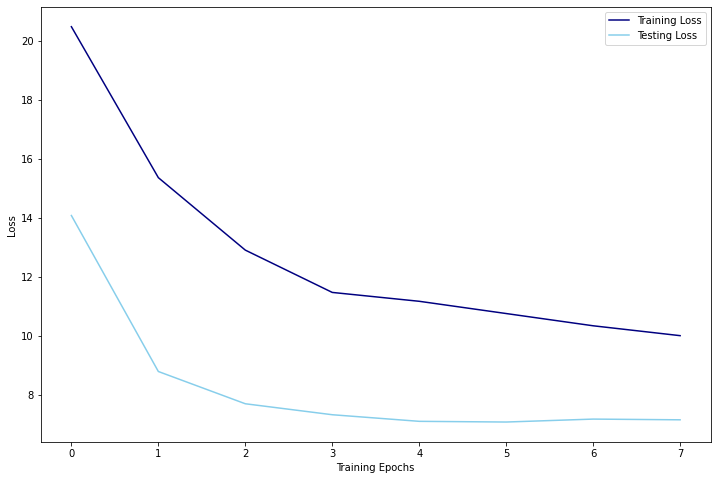

In [18]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss for the validation data of this model is lower than the loss for the training data, indicating that the model is doing well at adapting to new data. 

# Rouge scores for training data

In [26]:
#Get decoded predictions and labels from model
# code from https://huggingface.co/course/chapter7/5?fw=tf

all_preds = []
all_labels = []
for batch in tqdm(tf_validation):
    predictions = model.generate(**batch)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

100%|██████████| 3/3 [00:10<00:00,  3.54s/it]


In [27]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 9.027777777777779
recall: 5.24749373433584
f-measure: 6.648427171230287
***************
rouge2
precision: 0.0
recall: 0.0
f-measure: 0.0
***************
rougeL
precision: 9.122474747474747
recall: 5.334299289891395
f-measure: 6.722501245304359
***************
rougeLsum
precision: 8.080808080808081
recall: 4.714912280701754
f-measure: 5.968067774519388
***************


# Rouge scores for test data

In [28]:
#Process test data for input to model

tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=8
)

In [29]:
#Get decoded predictions and labels from putting test data through model
# (same process as above)

test_preds = []
test_labels = []
for batch in tqdm(tf_test):
    predictions = model.generate(**batch)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)


100%|██████████| 8/8 [00:40<00:00,  5.12s/it]


In [30]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')


rouge1
precision: 9.409340659340659
recall: 7.063492063492062
f-measure: 8.042328042328041
***************
rouge2
precision: 0.0
recall: 0.0
f-measure: 0.0
***************
rougeL
precision: 9.409340659340659
recall: 7.063492063492062
f-measure: 8.042328042328043
***************
rougeLsum
precision: 9.409340659340659
recall: 7.063492063492062
f-measure: 8.042328042328043
***************


# Example model-generated summaries

In [31]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [32]:
print(rand_indexes)

[58, 1, 43]


In [33]:
#Reference summary example 1
print(test_labels[58])

A sheer mountainside leads down to the Seventh Circle; they can only get down it where a landslide has sha


In [34]:
#Model summary example 1
print(test_preds[58])

<extra_id_0> the mountains of the mountains of the mountains of the mountains of the


In [35]:
#Reference summary example 2
print(test_labels[1])

Next, the UM uses the analogy of the road to present his conclusion that man is afraid of completing his goal.
Man


In [36]:
#Model summary example 2
print(test_preds[1])

<extra_id_0> the truth.
Gentlemen, I am joking, and I am joking


In [37]:
#Reference summary example 3
print(test_labels[43])

As they ran through the fields, Sikes had tried to bring Oliver with him.
After Toby abandoned them however


In [38]:
#Model summary example 3
print(test_preds[43])

<extra_id_0>


# Evaluation of Model

Based on rouge scores, this model performed worse than the three sentence summary baseline model. The example summaries generated do not make sense. Parameters need to be adjusted in order to improve predictions, and to allow for consideration of and generation of longer pieces of text